In [1]:
import os
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import wandb
from PIL import Image
from torch.utils.data import DataLoader

from helpers.generate_dataclass import SegmentationDataset
from helpers.plottingaftertraining import plot_after_training_deeplab, plot_after_training_unet
from helpers.testing import test_deeplab, test_unet
from helpers.training import train_deeplab, train_unet
from helpers.validating import validation_deeplab, validation_unet


In [2]:
torch.manual_seed(0)
np.random.seed(0)

# EDA

Im ersten Teil werde ich die Datenanalyse durchführen. Ich werde dabei die Bilder visuell und qualitativ untersuchen. Zuerst führe ich die Untersuchung auf den originalen Bildern durch. Danach werde ich sie mittels Dataloader einlesen und einerseits untersuchen, ob dabei Fehler passieren und danach untersuche ich die Bilder vertieft.

## Anzahl vorhandener Bilder

In [3]:
def count_images(folder):
    return len([name for name in os.listdir(folder)])

train_count = count_images('data/train/images')
test_count = count_images('data/test/images')
validation_count = count_images('data/validation/images')

print("Anzahl der Bilder in Train:", train_count)
print("Anzahl der Bilder in Test:", test_count)
print("Anzahl der Bilder in Validation:", validation_count)


Anzahl der Bilder in Train: 1385
Anzahl der Bilder in Test: 199
Anzahl der Bilder in Validation: 396


Im meinem Datensatz sind 1'385 Trainingsbilder, 200 Testbilder und 400 Bilder für die Verifikation vorhanden. Es sollten sich also um genügend Bilder handeln, um ein gutes Training durchzuführen. Der Train/Test Split ist mit 0.87 zwar relativ hoch, doch kann ich am Ende des Trainings zusätzlich die Verifikation Bilder als Test vom Modell verwenden.

## Inspektion der Bilder vor einlesen

Folgend stelle ich zehn Bilder und deren Masken vor, wie sie in der originalen Version vorhanden sind.

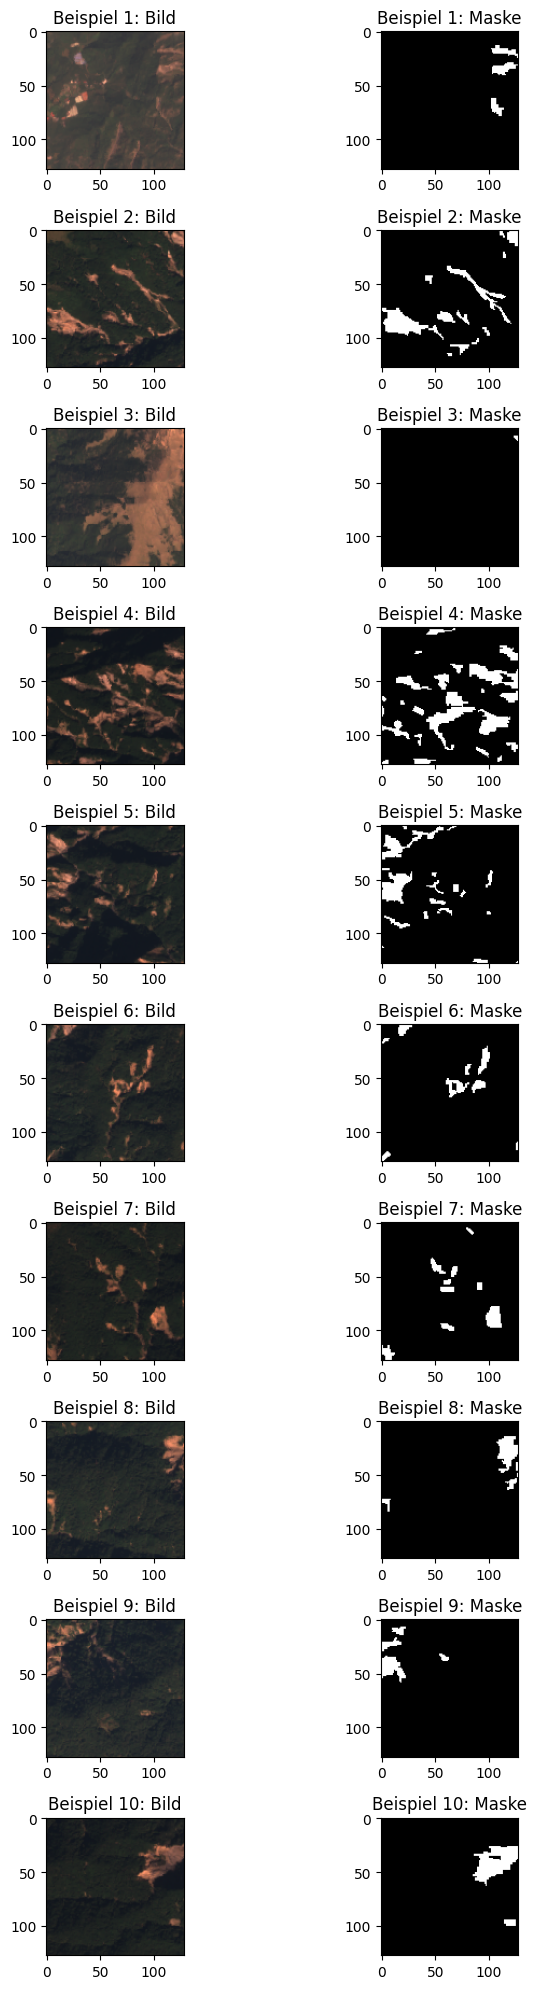

In [4]:
image_dir = 'data/train/images/'
mask_dir = 'data/train/masks/'

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

assert len(image_files) == len(mask_files)

fig, axs = plt.subplots(10, 2, figsize=(8, 20))

for i in range(10):
    # Bild
    image = Image.open(image_files[i])
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    # Maske
    mask = Image.open(mask_files[i])
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title(f'Beispiel {i + 1}: Maske')

plt.tight_layout()
plt.show()

Erkennbar ist grösstenteils bewaldetes Terrain. Dies ist neben der grünen Farbe auch leicht an der Wölbungen der Baumkronen erkennbar. Daneben fallen hellbraune Flecken auf, die versplittert über die Bilder verteilt sind. Anhand der Masken wird ersichtlich, dass es sich hierbei grösstenteils um die gesuchten Erdrutsche handelt. Diese kommen sehr unterschiedlich (in Bezug auf Form, Grösse und Häufigkeit), aber in jedem der angeschauten Bilder vor. Allerdings ist die Farbe keine Garantie, dass es sich um einen Erdrutsch handelt. Ich vermute, dass die restlichen braunen Formen, meistens schlangenförmig, Bäche oder Strassen sind. In weiteren angeschauten Bildern treten Bäche und Flüsse häufig auf und können einfach mit Erdrutschen verwechselt werden. Weiter sind die Wälder meistens relativ dunkel.

Die Masken selber scheinen nur aus zwei Farben, schwarz und weiss zu bestehen. Gemäss der Dokumentation der Challenge steht Klasse 0 (was der Farbe Schwarz entspricht), für Hintergrund und Klasse 1 (weiss) für Erdrutsche. Es wird auch ersichtlich, dass meistens deutlich mehr Hintergrund vorhanden ist.

## Überprüfung der Klassen in den Train Masken

Folgend untersuche die Farbmodi der Bilder und eine weitere Idee der Daten und notwendigen Aufbereitung zu erhalten. Gemäss Lones untersuche ich nicht alle Daten, sondern beschränke mich auf die Trainingsbilder, die rund 70% des Datensatzes ausmachen.

In [5]:
mode_counter_images = {}

for image_file in image_files:
    image_mode = Image.open(image_file).mode
    if image_mode in mode_counter_images:
        mode_counter_images[image_mode] += 1
    else:
        mode_counter_images[image_mode] = 1

print("Bilder: ", mode_counter_images)

mode_counter_masks = {}

for mask_file  in mask_files:
    mask_mode = Image.open(mask_file ).mode
    if mask_mode in mode_counter_masks:
        mode_counter_masks[mask_mode] += 1
    else:
        mode_counter_masks[mask_mode] = 1

print("Masken: ", mode_counter_masks)

Bilder:  {'RGBA': 1385}
Masken:  {'RGBA': 1385}


Sämtliche Bilder und Masken sind im Modus RGBA enthalten. Damit sollten keine speziellen Hürden bei dem Einlesen entstehen.

Folgend untersuche ich die Annahme, dass in den Masken nur zwei Klassen enthalten sind.

In [6]:
unique_values = set()

for mask_path in mask_files:
    mask = Image.open(mask_path)
    
    values = np.unique(np.array(mask))
    unique_values.update(values)

print("Anzahl unterschiedlicher Klassen/Farbtöne: ", len(unique_values))
print("Die unterschiedlichen Klassen/Farbtöne: ", values)

Anzahl unterschiedlicher Klassen/Farbtöne:  2
Die unterschiedlichen Klassen/Farbtöne:  [  0 255]


Wie erwähnt sind gemäss Dokumentation in den Masken nur zwei Klassen vorhanden. Farbton 0 entspricht, wie bei der visuellen Inspektion gesehen, der Klasse 0 und Farbton 255 den Erdrutschen. Ich werde diese Daten also in binär 0/1 umwandeln können.

## Überprüfung der unterschiedlichen Bildgrössen im Traindatensatz

Unterschiedliche Grössen der Bilder können das Training von Modellen erschweren. Ich werde deshalb auch diese Daten untersuchen.

In [7]:
unique_image_sizes = set()
unique_mask_sizes = set()

for image_file in image_files:
    with Image.open(image_file) as img:
        unique_image_sizes.add(img.size)

for mask_file in mask_files:
    with Image.open(mask_file) as mask:
        unique_mask_sizes.add(mask.size)

print("Einzigartige Bildgrößen:", unique_image_sizes)
print("Einzigartige Maskengrößen:", unique_mask_sizes)

Einzigartige Bildgrößen: {(128, 128)}
Einzigartige Maskengrößen: {(128, 128)}


Sämtliche Bilder und Masken haben die Grösse 128 x 128. Ich werde vorerst keinen Resize einbauen müssen. Höchstens wenn später fremde Bilder, die nicht in dem Datensatz vorhanden sind und entsprechend aufbereitet wurden, untersucht werden wollen, muss ein Resize berücksichtigt werden.

## Einlesen der Bilder für EDA

Nun werde ich die Daten in das Format, das für das Training notwendig ist, einlesen. Esi st wichtig, diese Bilder nochmals visuell zu untersuchen, da Transformationen durchgeführt werden und ich sicherstellen möchte, dass diese korrekt funktionieren. Im folgenden Beispiel werde ich die Daten aber nur in einen Tensor umwandeln, da ich die Bilder später auch qualitativ untersuche. Dabei sollen Transformationen wie Normalisierung die Resultate nicht verfälschen.

In [14]:
eda_train_data = SegmentationDataset(root='data', split='train', transform_mode='to_tensor')
eda_train_loader = DataLoader(eda_train_data, batch_size=64, shuffle=True)

## Inspektion der Bilder nach einlesen

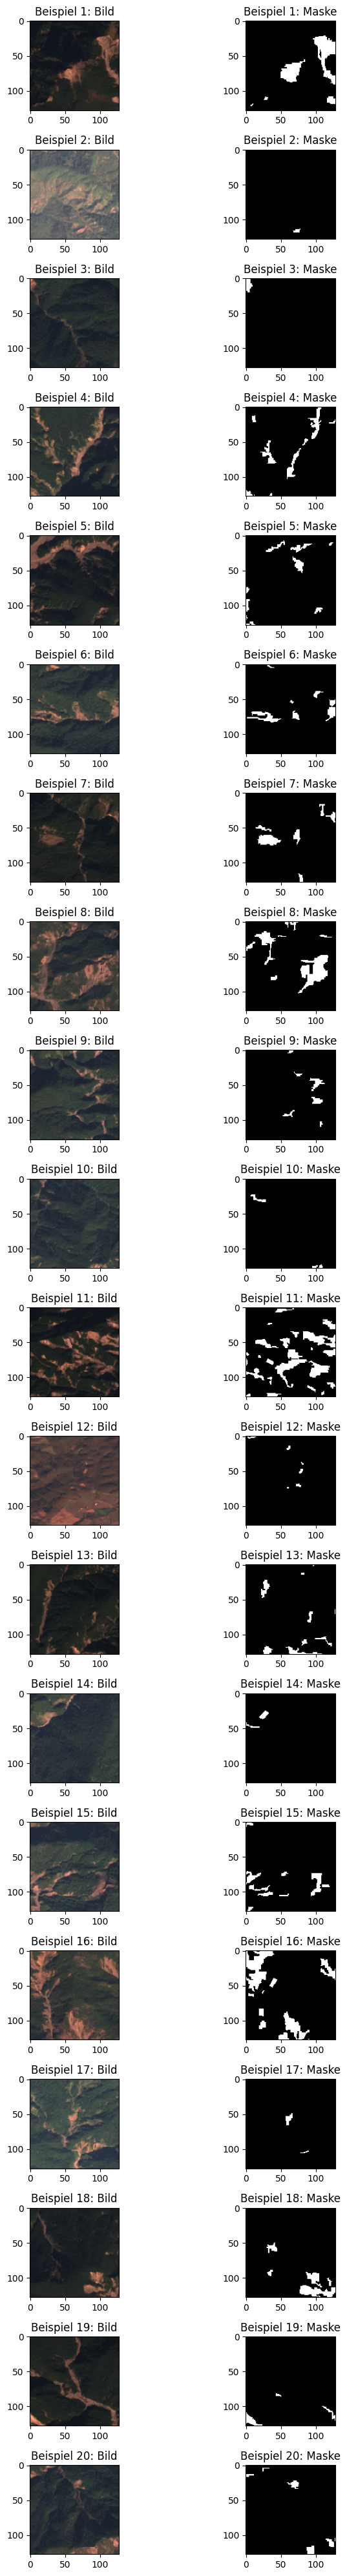

In [15]:
images, masks = next(iter(eda_train_loader))

fig, axs = plt.subplots(20, 2, figsize=(8, 40))  # 10 Reihen, 2 Spalten

for i in range(20):
    # Bild
    image = images[i].numpy().transpose((1, 2, 0))
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f'Beispiel {i + 1}: Bild')

    # Maske
    mask = masks[i][0].numpy()  # Beachte, dass wir nur den ersten Kanal für die Maske benötigen
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title(f'Beispiel {i + 1}: Maske')

plt.tight_layout()
plt.show()

Im Vergleich zu den zuvor angeschauten Bildern fällt mir die grössere Bandbreite an Farben und Helligkeiten bei den Bildern auf. Ersichtlich werden auch die erwähnten Flüsse, die ich teilweise mit Erdrutschen verwechselt habe. Insgesamt stimmen die Bilder (und der Qualität) weiterhin und die Masken entsprechen den dazugehörenden Bildern.

Ich habe auch die beiden Transformations-Methoden "normalize" und "flip" (inkl. Normierung) untersucht und konnte keine Probleme feststellen. Das Einlesen der Bilder funktioniert also wie gewünscht.

## Überprüfung der Bildergrössen

Ich bestätigte kurz, dass die Bilder weiterhin die gleiche Grösse aufweisen.

In [37]:
print("Grösser der Bilder:", images.shape)
print("Grösse der Masken:", masks.shape)

Grösser der Bilder: torch.Size([64, 3, 128, 128])
Grösse der Masken: torch.Size([64, 1, 128, 128])


Wie erwartet sind die Bilder weiterhin 128 x 128 gross. Der Wert 64 entspricht der gewünschten Batchsize, dieser Test ist ebenfalls positiv.

## Überprüfung der Klassen in den Train Masken

In [16]:
unique_values = set()

for images, masks in eda_train_loader:
    for mask in masks:
        values = np.unique(mask.numpy())
        unique_values.update(values)

print("Anzahl unterschiedlicher Klassen/Farbtöne: ", len(unique_values))
print("Die unterschiedlichen Klassen/Farbtöne: ", values)

Anzahl unterschiedlicher Klassen/Farbtöne:  2
Die unterschiedlichen Klassen/Farbtöne:  [0. 1.]


Wie ich bei den Originalen festgestellt habe, sind in den masken nur zwei Klassen vorhanden. Ich habe sie nun in die binären Werte 0/1 umgewandelt. Bei den Masken handelt es sich also nicht mehr um Bilder im grayscale, sondern sind binär.

## Verteilung der Klassen in den Train Masken
Das Verhältnis zwischen den Klassen kann im Deep Learning wichtig sein, weil Imbalance das Training und die Interpretation von Metriken erschweren kann.
In der folgenden Zelle untersuche ich das Verhältnis der beiden Klassen in den Trainingbildern.

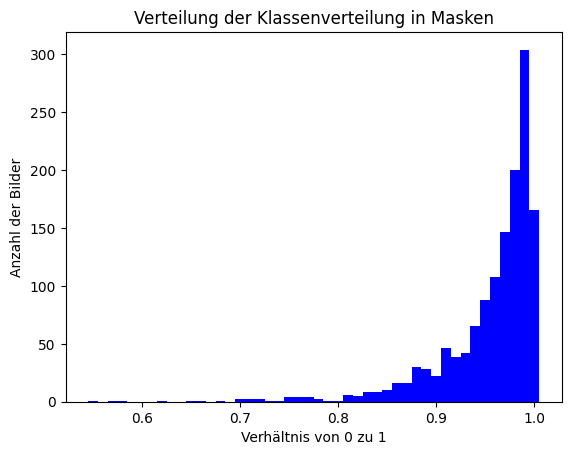

In [10]:
# Code mit ChatGPT erstellt

# Initialisieren Sie den Zähler
ratio_counter = defaultdict(int)

# Berechnen Sie das Verhältnis von 0 zu 1 für jedes Bild
for _, masks in eda_train_loader:
    for mask in masks:
        total_pixels = mask.numel()
        count_1 = torch.sum(mask).item()
        count_0 = total_pixels - count_1
        ratio = round(count_0 / (count_0 + count_1), 2)  # Rundet das Verhältnis auf zwei Dezimalstellen
        ratio_counter[ratio] += 1

# Erstellen Sie ein Histogramm mit matplotlib
ratios = list(ratio_counter.keys())
counts = [ratio_counter[ratio] for ratio in ratios]

plt.bar(ratios, counts, width=0.01, color='blue')
plt.xlabel('Verhältnis von 0 zu 1')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Klassenverteilung in Masken')
plt.show()

Das Histogramm zeigt auf, dass die Klassen sehr ungleichmässig verteilt sind. Die x-Achse entspricht dem Anteil Hintergrund zu Erdrutschen. Ein x-Wert von 0.9 entspricht 90% Hintergrund und 10% Erdrutsch. Die Verteilung zeigt, dass die meisten Bilder ein Verhältnis von über 0.9 aufweisen. Dies entspricht der visuellen Erkenntnis, dass viel mehr Hintergrund vorhanden ist.

Dies bedeutet, dass eine starke Imbalance vorhanden ist. Im Fall dieser Challenge gilt der F1 Score der Erdrutsche als Zielmetrik. Das ist vor dem Hintergrund der Imbalance eine gute Lösung, dass nur die Prognosen der untervertretenen Klasse berücksichtigt wird.

## Verteilung der Farben in den Train Bildern

Die Farben und deren Verteilung geben ein qualitatives Verständnis der Bilder. Es kann herausgefunden werden, ob Bilder zum Beispiel über- oder unterbelichtet sind oder ob einzelne Farben anders häufig vertreten sind.

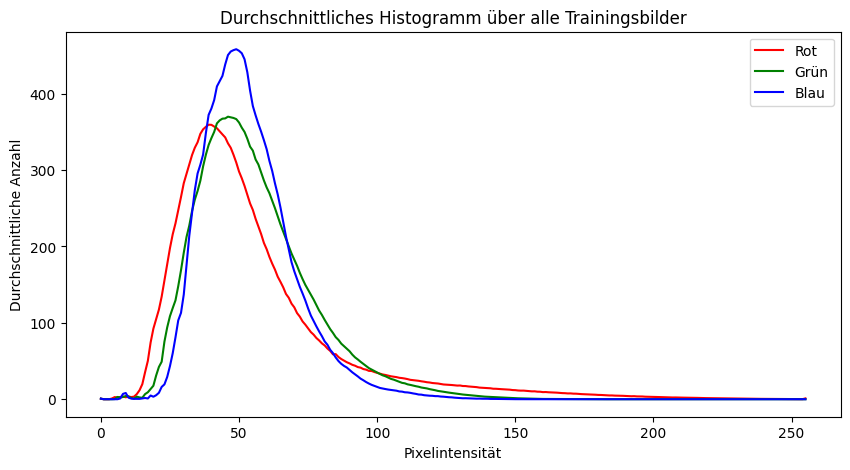

In [11]:
# Code mit ChatGPT erstellt

# Initialisiere Histogramm-Arrays
histogram_red = np.zeros(256)
histogram_green = np.zeros(256)
histogram_blue = np.zeros(256)

for images, _ in eda_train_loader:
    # Versichern Sie sich, dass die Bilder auf der CPU liegen (falls sie auf GPU geladen werden)
    images = images.cpu().numpy()
    
    # Die Form von `images` ist [batch_size, channels, height, width]
    for i in range(images.shape[0]):
        histogram_red += np.histogram(images[i, 0].flatten(), bins=256, range=(0, 1))[0]
        histogram_green += np.histogram(images[i, 1].flatten(), bins=256, range=(0, 1))[0]
        histogram_blue += np.histogram(images[i, 2].flatten(), bins=256, range=(0, 1))[0]

# Mitteln Sie die Histogramme über alle Bilder
num_images = len(eda_train_loader.dataset)
histogram_red /= num_images
histogram_green /= num_images
histogram_blue /= num_images

# Plotte die Histogramme
plt.figure(figsize=(10, 5))
plt.title("Durchschnittliches Histogramm über alle Trainingsbilder")
plt.xlabel("Pixelintensität")
plt.ylabel("Durchschnittliche Anzahl")
plt.plot(histogram_red, color='red', label='Rot')
plt.plot(histogram_green, color='green', label='Grün')
plt.plot(histogram_blue, color='blue', label='Blau')
plt.legend()
plt.show()

Die drei Farben kommen in etwa gleich häufig vor. Mit einem Wert um 50 ist die Intensität aber eher tief. Dies ist auch in den Bildern ersichtlich, wo der Wald häufig dunkel ist.

## Signal to Noise

Signal to Noise ist eine Metrik, die in unterschiedlichen [Usecases](https://spie.org/news/3421-enhancing-space-based-signal-to-noise-ratios-without-redesigning-the-satellite?SSO=1) im Bereich Signal und Bild zur Anwendung kommt. Sie liefert eine Kennzahl zur Bildqualität und misst das Signal im Verhältnis zum Noise.

In [114]:
def calculate_snr(image):
    mean_value = np.mean(image)
    std_deviation = np.std(image)
    return mean_value / std_deviation

snr_values = []

for images, _ in eda_train_loader:
    for image in images:
        img = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        snr = calculate_snr(img)
        snr_values.append(snr)

# Statistiken für das SNR berechnen:
average_snr = np.mean(snr_values)
max_snr = np.max(snr_values)
min_snr = np.min(snr_values)

print("Durchschnittliches SNR:", round(average_snr, 2))
print("Maximales SNR:", round(max_snr, 2))
print("Minimales SNR:", round(min_snr, 2))

Durchschnittliches SNR: 3.14
Maximales SNR: 9.72
Minimales SNR: 1.27


Ich habe kaum Angaben für ideale Werte für Bilder gefunden, laut [Wikipedia](https://en.wikipedia.org/wiki/Signal-to-noise_ratio_(imaging)) ist aber ein Verhältnis von 10 ein akzeptabler Wert. Mit einem durchschnittlichen SNR von 3.14 sind meine Bilder allerdings deutlich darunter und weisen eine hohe Schwankung auf. Dass die Bilder nicht von sehr hoher Qualität sind, habe ich bei der visuellen Inspektion gesehen, der Wert scheint aber doch sehr tief zu sein. Ich gehe  nicht davon aus, dass ich ihn mit den klassichen Data Augmentation Verfahren von Pytorch merklich verbessern kann.

## Untersuchung des Kontrasts

Für die Berechnung des Kontrasts verwende ich die [RMS contrast](https://en.wikipedia.org/wiki/Contrast_(vision)#RMS_contrast) Methode. Der Kontrast sagt aus, wie stark sich die hellen und dunklen Bereiche eines Bildes unterscheiden.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Durchschnittlicher Kontrast: 14.27
Maximaler Kontrast: 38.45
Minimaler Kontrast: 2.81


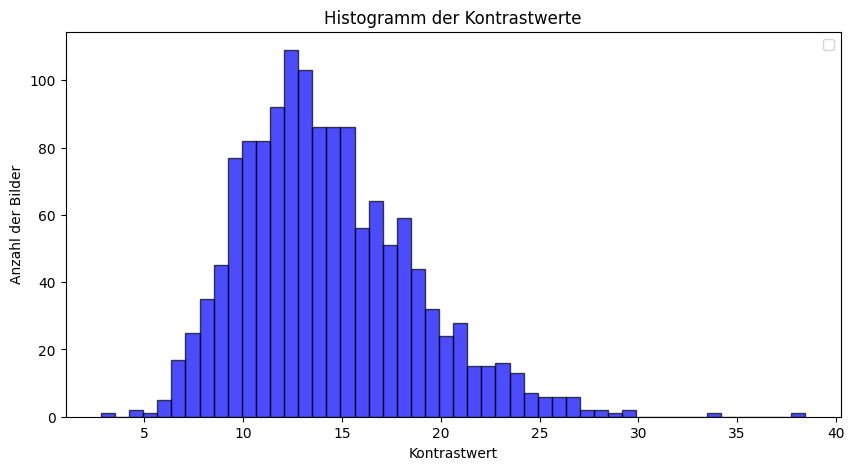

In [34]:
def calculate_contrast(image):
    # Konvertieren Sie das Bild in Graustufen für die Kontrastanalyse
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Der Kontrast ist die Standardabweichung der Pixelwerte
    return np.std(gray)

contrast_values = []

for images, _ in eda_train_loader:
    for image in images:
        img = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        contrast = calculate_contrast(img)
        contrast_values.append(contrast)

# Statistiken für den Kontrast berechnen
average_contrast = np.mean(contrast_values)
max_contrast = np.max(contrast_values)
min_contrast = np.min(contrast_values)

print("Durchschnittlicher Kontrast:", round(average_contrast, 2))
print("Maximaler Kontrast:", round(max_contrast, 2))
print("Minimaler Kontrast:", round(min_contrast, 2))

# Plotte die Histogramme
plt.figure(figsize=(10, 5))
plt.hist(contrast_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Histogramm der Kontrastwerte")
plt.xlabel("Kontrastwert")
plt.ylabel("Anzahl der Bilder")
plt.legend()
plt.show()

Auch hier ist es schwierig, einen idealen Wert zu finden. Wichtig ist aus meiner Sicht, dass die Bandbreite wieder sehr hoch ist. Im Histogramm wird ersichtlich, dass die meisten Werte zwischen 10 und 20 liegen.

## Untersuchung der Komponenten

Nun werde ich die Erdrutsche untersuchen. Ich versuche herauszufinden, ob es Unterschiede zum restlichen Bild gibt.

Im ersten Schritt probiere ich die Funktionsweise von cv2.connectedComponentsWithStats aus und plotte für ein Bild die gefundenen Komponenten. Ich verwende dafür die Masken, weil dort die Komponenten entweder Hintergrund oder Erdrütsche sein müssen.

Anzahl Komponenten:  12
Grösse der Komponenten:  [15512   108   122    69    32   103    81    81   146    61    20    49]


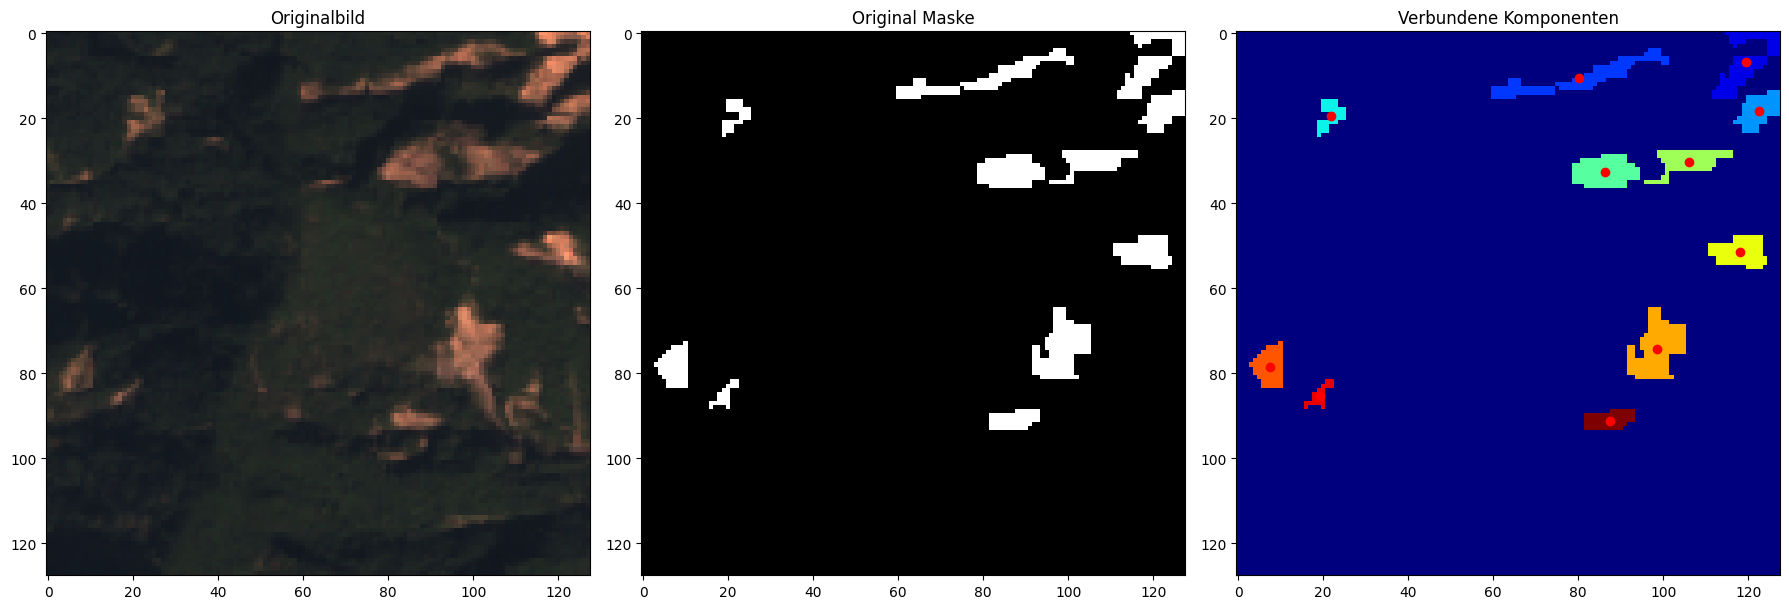

In [132]:

# Ihr bestehender Code
images, masks = next(iter(eda_train_loader))

# Bild und Maske extrahieren
image = images[0].numpy().transpose(1, 2, 0)  # (C, H, W) zu (H, W, C)
mask = masks[0].numpy().squeeze(0)
if mask.dtype != np.uint8:
    mask = mask.astype(np.uint8)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
print("Anzahl Komponenten: ", num_labels)
print("Grösse der Komponenten: ", stats[:, cv2.CC_STAT_AREA])

# Visualisierung
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Originalbild anzeigen
ax[0].imshow(image)  
ax[0].set_title("Originalbild")

# Originalmaske anzeigen
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Original Maske")

# Labels anzeigen
ax[2].imshow(labels, cmap="jet")
ax[2].set_title("Verbundene Komponenten")

# optional: Zentroide hinzufügen
for c in centroids[1:]:  
    ax[2].plot(c[0], c[1], 'ro')  

plt.tight_layout()
plt.show()

Dieser Plot zeigt, dass mit der gewählten Funktion auf Masken gut die Erdrutsche erkannt werden. Ich erhalte weiter die Anzahl die Anzahl der gefundenen Komponenten und die Pixelgrösse. Da der Hintergrund auch als Komponente gezählt wird, muss die Anzahl um 1 reduziert werden und die Grösse der ersten Komponente kann ignoriert werden.

Nun zähle ich die Anzahl Komponenten und stelle sie ins Verhältnis.

In [91]:
n_komponenten = 0
size_komponenten = 0
n_masks = 0

for images, masks in eda_train_loader:
    for maske in masks:
        mask = maske.numpy().squeeze(0).astype(np.uint8)

        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(mask)
        
        n_komponenten += (num_labels - 1)
        size_komponenten += np.sum(stats[1:, cv2.CC_STAT_AREA])
    
    n_masks += len(masks)

mean_components = n_komponenten / n_masks
mean_size = size_komponenten / n_komponenten 

print("Durchschnittliche Anzahl von Komponenten pro Bild:", round(mean_components, 2))
print("Durchschnittliche Grösse der Komponenten in Pixel:", round(mean_size, 2))

Durchschnittliche Anzahl von Komponenten pro Bild: 6.77
Durchschnittliche Grösse der Komponenten in Pixel: 108.83


Über alle Trainingbilder kommen durchschnittlich 6.8 Komponenten (resp. Erdrutsch) vor und sie haben eine gemittelte Grösse von 109 Pixel.

Die Grösse ist im Verhältnis zum gesamten Bilder (16'384 Pixel) sehr klein. Dies bestätigt die visuelle Erkenntnis.

In [88]:
print("Anzahl Pixel pro Maske:", mask.shape[0] * mask.shape[1])

Anzahl Pixel pro Maske: 16384


Ich untersuche nun die Verteilung der Grösse der Erdrutsche.

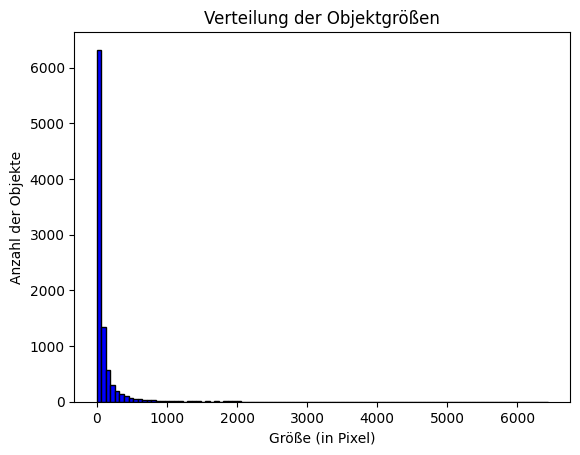

In [18]:
# Liste, um die Größen aller gefundenen Komponenten zu speichern
component_sizes = []

for _, masks in eda_train_loader:
    for mask in masks:
        # Umwandeln des Tensors in ein Numpy-Array
        mask_np = mask.squeeze(0).numpy().astype(np.uint8)

        # Finde die verbundenen Komponenten und ihre Statistiken
        _, _, stats, _ = cv2.connectedComponentsWithStats(mask_np, connectivity=8)

        # Extrahiere die Größen der gefundenen Komponenten (ignoriere den Hintergrund)
        for i, stat in enumerate(stats):
            if i != 0:  # Hintergrund ignorieren
                component_sizes.append(stat[cv2.CC_STAT_AREA])

# Erstelle ein Histogramm der Komponentengrößen
plt.hist(component_sizes, bins=100, color='blue', edgecolor='black')
plt.title('Verteilung der Objektgrößen')
plt.xlabel('Größe (in Pixel)')
plt.ylabel('Anzahl der Objekte')
plt.show()


Dieses Histogramm zeigt, dass die allermeisten Komponenten sehr klein sind. Es gibt kaum Ausreisser mit einer grösse über 300 Pixel. Dies bestätigt auch die zuvor gemachte Untersuchung der Verhältnisse zwischen Hintergrund und Erdrutsche.

## Verteilung der Farben der Komponenten

Aufgrund der visuellen Inspektion vermute ich, dass die Erdrutsche andere Farbmuster aufweisen.

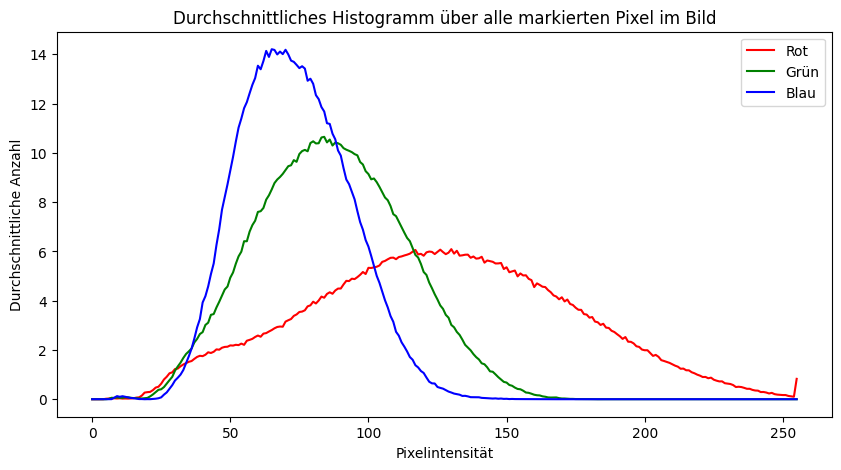

In [19]:
# Initialisiere Histogramm-Arrays
histogram_red = np.zeros(256)
histogram_green = np.zeros(256)
histogram_blue = np.zeros(256)

component_count = 0

for images, masks in eda_train_loader:
    # Versichern Sie sich, dass die Bilder auf der CPU liegen (falls sie auf GPU geladen werden)
    images = images.cpu().numpy()

    for idx, mask in enumerate(masks):
        # Umwandeln des Tensors in ein Numpy-Array
        mask_np = mask.squeeze(0).numpy().astype(np.uint8)
        
        # Erhalte nur die Pixel, die den Wert 1 in der Maske haben
        component_mask = (mask_np == 1)

        # Wenn es Pixel in der Komponentenmaske gibt, führe die Analyse durch
        if np.any(component_mask):
            component_count += 1

            # Extrahieren der Pixelwerte des Bildes, die innerhalb der Maske liegen
            red_values = images[idx, 0][component_mask].flatten()
            green_values = images[idx, 1][component_mask].flatten()
            blue_values = images[idx, 2][component_mask].flatten()

            # Aktualisieren der Histogramme für jeden Kanal
            histogram_red += np.histogram(red_values, bins=256, range=(0, 1))[0]
            histogram_green += np.histogram(green_values, bins=256, range=(0, 1))[0]
            histogram_blue += np.histogram(blue_values, bins=256, range=(0, 1))[0]

# Mitteln Sie die Histogramme über alle Komponenten
histogram_red /= component_count
histogram_green /= component_count
histogram_blue /= component_count

# Plotte die Histogramme
plt.figure(figsize=(10, 5))
plt.title("Durchschnittliches Histogramm über alle markierten Pixel im Bild")
plt.xlabel("Pixelintensität")
plt.ylabel("Durchschnittliche Anzahl")
plt.plot(histogram_red, color='red', label='Rot')
plt.plot(histogram_green, color='green', label='Grün')
plt.plot(histogram_blue, color='blue', label='Blau')
plt.legend()
plt.show()

Das Histogramm der Trainingsbilder bestätigt, dass die Farben der Erdrutsche anders sind. Insbesondere die Farbe Rot weist einen höheren Mittelwert und Streuung auf. Auch die Farben Blau und Grün weisen einen höheren Mittelwert auf. Die Erdrutsche sind also heller und weisen einen höheren rot-Stich aus, was in der visuellen Inspektion erkennbar war.

## Untersuchung der Bildschärfe

Folgend untersuche ich die Unschärfe der Erdrutsche und vergleiche sie mit der Unschärfe der gesamten Bilder. Ich verwende dafür die [variance of the Laplacian](https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/) Methode.

In [29]:
def estimate_blur(image, mask):
    # Nur Pixel auswählen, die in der Maske den Wert 1 haben
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm

blur_scores_masked = []

for images, masks in eda_train_loader:
    for idx, image in enumerate(images):
        img = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        mask = masks[idx].squeeze(0).numpy().astype(np.uint8) * 255  # Maske auf den Wertebereich [0, 255] skalieren
        blur_score = estimate_blur(img, mask)
        blur_scores_masked.append(blur_score)

# Statistiken für die Unschärfe berechnen:
average_blur = np.mean(blur_scores_masked)
max_blur = np.max(blur_scores_masked)
min_blur = np.min(blur_scores_masked)

print("Durchschnittliche Unschärfe in der Maske:", round(average_blur, 2))
print("Maximale Unschärfe in der Maske:", round(max_blur, 2))
print("Minimale Unschärfe in der Maske:", round(min_blur, 2))

Durchschnittliche Unschärfe in der Maske: 464.4
Maximale Unschärfe in der Maske: 3034.71
Minimale Unschärfe in der Maske: 0.0


In [30]:
def estimate_blur(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm

blur_scores_whole = []

for images, _ in eda_train_loader:
    for image in images:
        img = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        blur_score = estimate_blur(img)
        blur_scores_whole.append(blur_score)

# Statistiken für die Unschärfe berechnen:
average_blur = np.mean(blur_scores_whole)
max_blur = np.max(blur_scores_whole)
min_blur = np.min(blur_scores_whole)

print("Durchschnittliche Unschärfe im gesamten Bild:", round(average_blur, 2))
print("Maximale Unschärfe im gesamten Bild:", round(max_blur, 2))
print("Minimale Unschärfe im gesamten Bild:", round(min_blur, 2))

Durchschnittliche Unschärfe im gesamten Bild: 159.17
Maximale Unschärfe im gesamten Bild: 573.14
Minimale Unschärfe im gesamten Bild: 11.67


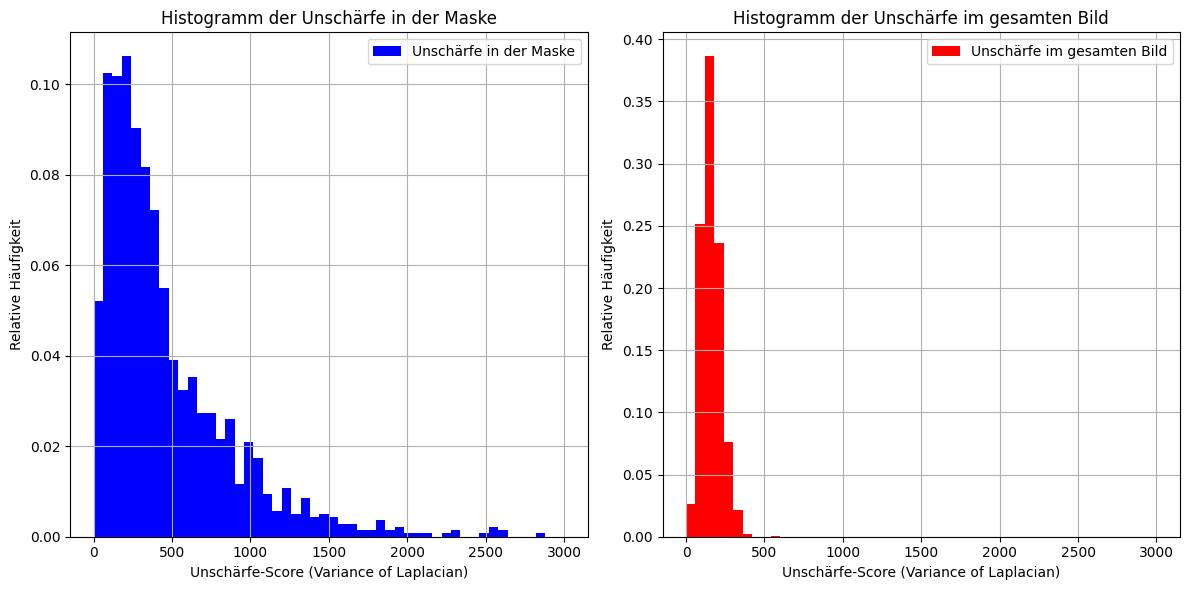

In [31]:
plt.figure(figsize=(12, 6))

# Histogramm für Unschärfe in der Maske (relativ)
plt.subplot(1, 2, 1)
weights_masked = np.ones_like(blur_scores_masked) / len(blur_scores_masked)
plt.hist(blur_scores_masked, bins=50, range=(0, 3000), weights=weights_masked, color='blue', label='Unschärfe in der Maske')
plt.xlabel('Unschärfe-Score (Variance of Laplacian)')
plt.ylabel('Relative Häufigkeit')
plt.title('Histogramm der Unschärfe in der Maske')
plt.legend()
plt.grid(True)

# Histogramm für Unschärfe im gesamten Bild (relativ)
plt.subplot(1, 2, 2)
weights_whole = np.ones_like(blur_scores_whole) / len(blur_scores_whole)
plt.hist(blur_scores_whole, bins=50, range=(0, 3000), weights=weights_whole, color='red', label='Unschärfe im gesamten Bild')
plt.xlabel('Unschärfe-Score (Variance of Laplacian)')
plt.ylabel('Relative Häufigkeit')
plt.title('Histogramm der Unschärfe im gesamten Bild')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Diese Histogramm vergleichen die relative Häufigkeit der Unschärfe-Scores pro Pixel. Im linken Histogramm wurde für die Berechnung des Scores nur die Pixel der Erdrutsche verwendet, während rechts das gesamte Bild angeschaut wurde. Es wird ersichtlich, dass die Erdrutsche deutlich höhere Scores aufweisen können, verglichen mit den gesamten Bildern. Ein höherer Score bedeutet, dass Schärfe besser ist.

Ich vermute, dass die Schärfe bei Erdrutschen höher ist, als bei den Wälder, weil die Baumkronen meistens das gleiche Muster aufweisen und die Wälder deshalb eher als Fläche dargestellt werden. Bei Erdrutschen sind mehr Details zu erkennen, was vermutlich zu den höheren Scores führt.

## Rand-Intensitätsanalyse

Ich untersuche zuletzt auch die Ränder der Komponenten/Erdrutsche. Ich möchte dabei feststellen, ob ein Unterschied zum restlichen Bild festgestellt werden kann. Da die Ränder sehr dünn sind, bin ich vorerst noch skeptisch.

Ich lege keinen starken Wert auf diese Untersuchung, den der Code wurde mit viel Try/Error mit ChatGPT erstellt. Auch wenn das Resultat plausibel erscheint, besteht ein Risiko, weil ich nicht die einzelne Komponenten testen konnte. Trotzdem finde ich es eine interessante Untersuchung und führe sie durch. 

In [36]:
kernel = np.ones((3,3),np.uint8)

def get_inner_outer_edge_pixels(mask):
    dilation = cv2.dilate(mask, kernel, iterations=1)   # Erweitert die Ränder der Maske nach außen
    erosion = cv2.erode(mask, kernel, iterations=1)     # Verengt die Ränder der Maske nach innen
    
    inner_edge = mask - erosion         # Pixel knapp innerhalb der Ränder isolieren
    outer_edge = dilation - mask        # Pixel knapp außerhalb der Ränder isolieren
    
    return inner_edge, outer_edge


def calculate_edge_intensity(image, mask):
    # Identifizieren Sie die Komponenten in der Maske
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    # Konvertieren Sie das Bild in Graustufen für die Intensitätsanalyse
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    edge_intensities = []
    component_intensities = []

    # Gehe durch alle identifizierten Komponenten
    for i in range(1, num_labels): # Starten Sie bei 1, um den Hintergrund zu überspringen
        # Erzeugen Sie eine Maske nur für die aktuelle Komponente
        component_mask = (labels == i).astype(np.uint8) * 255

        # Berechnen Sie die Intensität der gesamten Komponente
        component_intensity = np.mean(gray[component_mask == 255])
        component_intensities.append(component_intensity)

        # Finden Sie die Ränder der Komponente
        contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Überprüfen Sie, ob Konturen gefunden wurden
        if not contours:
            continue

        for contour in contours:
            for point in contour:
                x, y = point[0]
                edge_intensities.append(gray[y, x])

    # Wenn keine Randintensitäten erfasst wurden, geben Sie None zurück
    if not edge_intensities:
        return None, None, None

    # Berechnen Sie die durchschnittliche Intensität und den Kontrast
    average_intensity = np.mean(edge_intensities)
    contrast = np.std(edge_intensities)
    average_component_intensity = np.mean(component_intensities)

    return average_intensity, contrast, average_component_intensity

intensity_values = []
contrast_values = []
component_intensities = []
differences = []

for images, masks in eda_train_loader:
    for image, mask_tensor in zip(images, masks):
        img = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        mask = mask_tensor.numpy().squeeze(0).astype(np.uint8)

        average_intensity, contrast, comp_intensity = calculate_edge_intensity(img, mask)
        
        # Überprüfen Sie, ob gültige Werte zurückgegeben wurden
        if average_intensity is not None and contrast is not None and comp_intensity is not None:
            intensity_values.append(average_intensity)
            contrast_values.append(contrast)
            component_intensities.append(comp_intensity)
        
                # Ränder isolieren
        inner_edge, outer_edge = get_inner_outer_edge_pixels(mask)

        # Pixelwerte an den isolierten Rändern extrahieren
        inner_edge_values = img[inner_edge == 1]
        outer_edge_values = img[outer_edge == 1]
        
        # Die Differenz der mittleren Werte berechnen
        if inner_edge_values.size > 0 and outer_edge_values.size > 0:
            diff = np.mean(inner_edge_values) - np.mean(outer_edge_values)
            differences.append(diff)

# Statistiken berechnen
average_intensity = np.mean(intensity_values) if intensity_values else None
average_contrast = np.mean(contrast_values) if contrast_values else None
average_comp_intensity = np.mean(component_intensities) if component_intensities else None
average_diff = np.mean(differences) if differences else None

print("Durchschnittliche Rand-Intensität:", round(average_intensity, 2) if average_intensity is not None else "N/A")
print("Durchschnittliche Intensität der Komponenten:", round(average_comp_intensity, 2) if average_comp_intensity is not None else "N/A")
print("Durchschnittliche Differenz der Intensität zwischen inneren und äußeren Rändern:", round(average_diff, 2) if average_diff is not None else "N/A")
print("Durchschnittlicher Kontrast an den Rändern:", round(average_contrast, 2) if average_contrast is not None else "N/A")

Durchschnittliche Rand-Intensität: 85.59
Durchschnittliche Intensität der Komponenten: 91.57
Durchschnittliche Differenz der Intensität zwischen inneren und äußeren Rändern: 21.65
Durchschnittlicher Kontrast an den Rändern: 20.1


Die Graustufen Intensität an den Rändern beträgt 85.6 und die Intensität der gesamten Komponenten 91.6. Die Differenz der Intensität von knapp innerhalb zu knapp ausserhalb der Ränder beträgt 21.6.

Ein Vergleich und Einschätzung folgt nach der Berechnung der Intensität des gesamten Bildes.

In [117]:
def calculate_image_intensity_and_contrast(image):
    # Konvertieren Sie das Bild in Graustufen für die Intensitätsanalyse
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Berechnen Sie die durchschnittliche Intensität und den Kontrast
    average_intensity = np.mean(gray)
    contrast = np.std(gray)

    return average_intensity, contrast

intensity_values = []
contrast_values = []

for images, _ in eda_train_loader:  # Sie benötigen keine Masken für diese Analyse
    for image in images:
        img = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

        average_intensity, contrast = calculate_image_intensity_and_contrast(img)
        intensity_values.append(average_intensity)
        contrast_values.append(contrast)

# Statistiken berechnen
average_intensity = np.mean(intensity_values)
average_contrast = np.mean(contrast_values)

print("Durchschnittliche Intensität:", round(average_intensity, 2))
print("Durchschnittlicher Kontrast:", round(average_contrast, 2))


Durchschnittliche Intensität: 54.8
Durchschnittlicher Kontrast: 14.27


Die Komponenten haben eine Intensität von 91.6, verglichen mit lediglich 54.8 über das gesamte Bild. Die Erdrutsche sind also deutlich heller, als die restlichen Teil des Bildes. Das bestätigt bereits getroffene Feststellungen. Da die Intensität an den Rändern der Erdrutsche um 21.6 steigt, deutet das darauf hin, dass die Ränder eine klar erkennbar Kante darstellen. Sollte dieses Resultat stimmen, gehe ich davon aus, dass auch die Modelle gut daran lernen können.

Zusätzlich habe ich den Kontrast vom gesamten Bild und den Komponenten berechnet. Dieser ist bei den Komponenten mit 20.1 merklich höher als beim gesamten Bild mit 14.3.

## Zusammenfassung von EDA

Die explorative Datenanalyse der Bilder hat interessante Erkenntnisse geliefert. Zum einen hat sich gezeigt, dass die Bilderqualität nicht sehr hoch ist. Auch sind die Erdrutsche relativ klein. Trotzdem unterscheiden sie sich vom Hintergrund in mehreren qualitativen Aspekten, wie Farbtöne, Kontrast, Schärfe und Intensität/Helligkeit. Ich gehe deshalb davon aus, dass trotz negativer Aspekte die Modelle die Erdrutsch lernen und segmentieren können.

# Vorbereitung der Codes fürs Training

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda


In [4]:
def do_modeltrain_deeplab(epochs, train_dataloader, test_dataloader, val_dataloader, model, loss_fn, optimizer, device):
    for t in range(epochs):
        train_loss = train_deeplab(train_dataloader, model, loss_fn, optimizer, device)
        test_loss, test_f1_background, test_f1_landslide = test_deeplab(test_dataloader, model, loss_fn, device)
        
        # Übermittlung der Daten an W&B
        wandb.log({"Train loss": train_loss, "Test loss": test_loss, "Test F1 Background": test_f1_background, "Test F1 Landslides": test_f1_landslide})
        print(t, " Train loss:", train_loss, "Test loss:", test_loss, "Test F1 Background:", test_f1_background, "Test F1 Landslides:", test_f1_landslide)

    val_loss, f1_value_background, f1_value_landslide = validation_deeplab(val_dataloader, model, loss_fn, device)
    wandb.log({"Val Loss": val_loss, "Val F1 Background": test_f1_background, "Val F1 Landslides": test_f1_landslide})

    print("Validation Loss: ", val_loss, "Val F1 Background: ", f1_value_background, "Val F1 Landslides: ", f1_value_landslide)

In [5]:
def do_modeltrain_unet(epochs, train_dataloader, test_dataloader, val_dataloader, model, loss_fn, optimizer, device):
    for t in range(epochs):
        train_loss = train_unet(train_dataloader, model, loss_fn, optimizer, device)
        test_loss, test_f1_background, test_f1_landslide = test_unet(test_dataloader, model, loss_fn, device)
        
        # Übermittlung der Daten an W&B
        wandb.log({"Train loss": train_loss, "Test loss": test_loss, "Test F1 Background": test_f1_background, "Test F1 Landslides": test_f1_landslide})
        print(t, "Train loss:", train_loss, "Test loss:", test_loss, "Test F1 Background:", test_f1_background, "Test F1 Landslides:", test_f1_landslide)

    val_loss, f1_value_background, f1_value_landslide = validation_unet(val_dataloader, model, loss_fn, device)
    wandb.log({"Val Loss": val_loss, "Val F1 Background": test_f1_background, "Val F1 Landslides": test_f1_landslide})

    print("Validation Loss: ", val_loss, "Val F1 Background: ", f1_value_background, "Val F1 Landslides: ", f1_value_landslide)

# Baseline

Wie erwähnt handelt es sich beim Datensatz um eine Challenge [Landslide4Sense-2022](https://www.iarai.ac.at/landslide4sense/). Im Github Repo haben sie neben unzähligen Informationen und Anleitungen ein eigenes Baseline-Resultat veröffentlicht. Mit dem Validation Set haben mit U-Net einen F1 Score von 57.82 erzielt. Ich nehme deshalb dieses Resultat als mein Baseline und werde meine eigenen Modelle mit diesem Resultat vergleichen.

Bevor ich meine eigenen Modelle trainiere, habe ich das Model, das der Challenge-Owner zur Erstellung der Baseline verwendet hat, angeschaut:
- Bildergrösse = 128x128: Die originalen Bilder haben bereits diese Grösse und ich belasse diese unverändert.
- Anzahl Klassen = 2: Dies entspricht gemäss EDA auch meiner Anzahl Klassen.
- Batchsize = 32: Ich werde unterschiedliche Batchgrössen untersuchen.
- Learning Rate = 1e-2: Auch hier werde ich unterschiedliche Werte untersuchen. Da ich bei Versuchen festgestellt habe, dass 1e-2 auch ein guter Wert ist, werde ich mit diesem starten.
- Number Training steps = 5000: Ich verstehe nicht ganz, ob damit die Trainingsepochen gemeint ist. Aufgrund Resourcenbeschränkungen werde ich mit deutlich weniger Epochen, im tieferen zweistelligen Bereich, arbeiten.
- Weight Decay = 5e-4: Ich werde vorläufig keinen Penalty verwenden, ihn aber bei der Regularisierung untersuchen.
- Optimizer = Adam: Ich werde den selben Optimizer verwenden.
- Loss = CrossEntropyLoss: Auch hier verwende ich die selbe Metrik.


# Overfit
Ich werde die Modelle U-Net und Deeplabv3 untersuchen. Beim U-Net bin ich insbesondere gespannt, ob und wie stark ich das Baseline der Challenge-Owner übertreffen kann.

## Overfit U-Net

In [6]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Overfit U-Net",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [50]},
        "learn_rate": {"values": [1e-4]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

# 50, 1e-2, 64

In [7]:
sweep_overfit_u = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Overfit U-Net",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='to_tensor')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=2, init_features=2, pretrained=False)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_unet(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_unet(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_overfit_u.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_overfit_u, function=main)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: awmya9gr
Sweep URL: https://wandb.ai/patschue/DLBS_Landslides%20Overfit%20U-Net/sweeps/awmya9gr


wandb: Agent Starting Run: r9kvr9q7 with config:
wandb: 	batchsize: 64
wandb: 	epochs: 50
wandb: 	l2_penalty: 0
wandb: 	learn_rate: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: patschue. Use `wandb login --relogin` to force relogin


Using cache found in C:\Users\schue/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


0 Train loss: 0.6957853084260767 Test loss: 0.6980013847351074 Test F1 Background: 0.5363441109657288 Test F1 Landslides: 0.0774274691939354
1 Train loss: 0.6928289668126539 Test loss: 0.6853410601615906 Test F1 Background: 0.7866255044937134 Test F1 Landslides: 0.09900378435850143
2 Train loss: 0.6897856024178591 Test loss: 0.6852529048919678 Test F1 Background: 0.687455952167511 Test F1 Landslides: 0.07860279083251953
3 Train loss: 0.6869811144742098 Test loss: 0.6858013868331909 Test F1 Background: 0.6478403210639954 Test F1 Landslides: 0.06803975999355316
4 Train loss: 0.6844736527312886 Test loss: 0.6836163550615311 Test F1 Background: 0.6549977660179138 Test F1 Landslides: 0.06310934573411942
5 Train loss: 0.6823200691830028 Test loss: 0.681468278169632 Test F1 Background: 0.6634492874145508 Test F1 Landslides: 0.060431141406297684
6 Train loss: 0.6803663698109713 Test loss: 0.6797659397125244 Test F1 Background: 0.6682993769645691 Test F1 Landslides: 0.0587681345641613
7 Train l

## Overfit Deeplabv3

In [17]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Overfit Deeplabv3",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [2]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: x171sh6x
Sweep URL: https://wandb.ai/patschue/DLBS_Landslides%20Overfit/sweeps/x171sh6x


wandb: Agent Starting Run: erapnlx1 with config:
wandb: 	batchsize: 64
wandb: 	epochs: 2
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: patschue. Use `wandb login --relogin` to force relogin


Training done


/Users/patrickschuermann/.local/share/virtualenvs/Deep_Learning-EdiEON_k/lib/python3.9/site-packages/torchmetrics/functional/classification/stat_scores.py:408: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp


0  Train loss: 0.21773888848044656 Test loss: 5512.619323730469 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
Training done
1  Train loss: 0.13755563138560814 Test loss: 0.35989394783973694 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
Validation Loss:  0.5824933669396809 Val F1 Background:  0.9791943430900574 Val F1 Landslides:  0.0
Done!


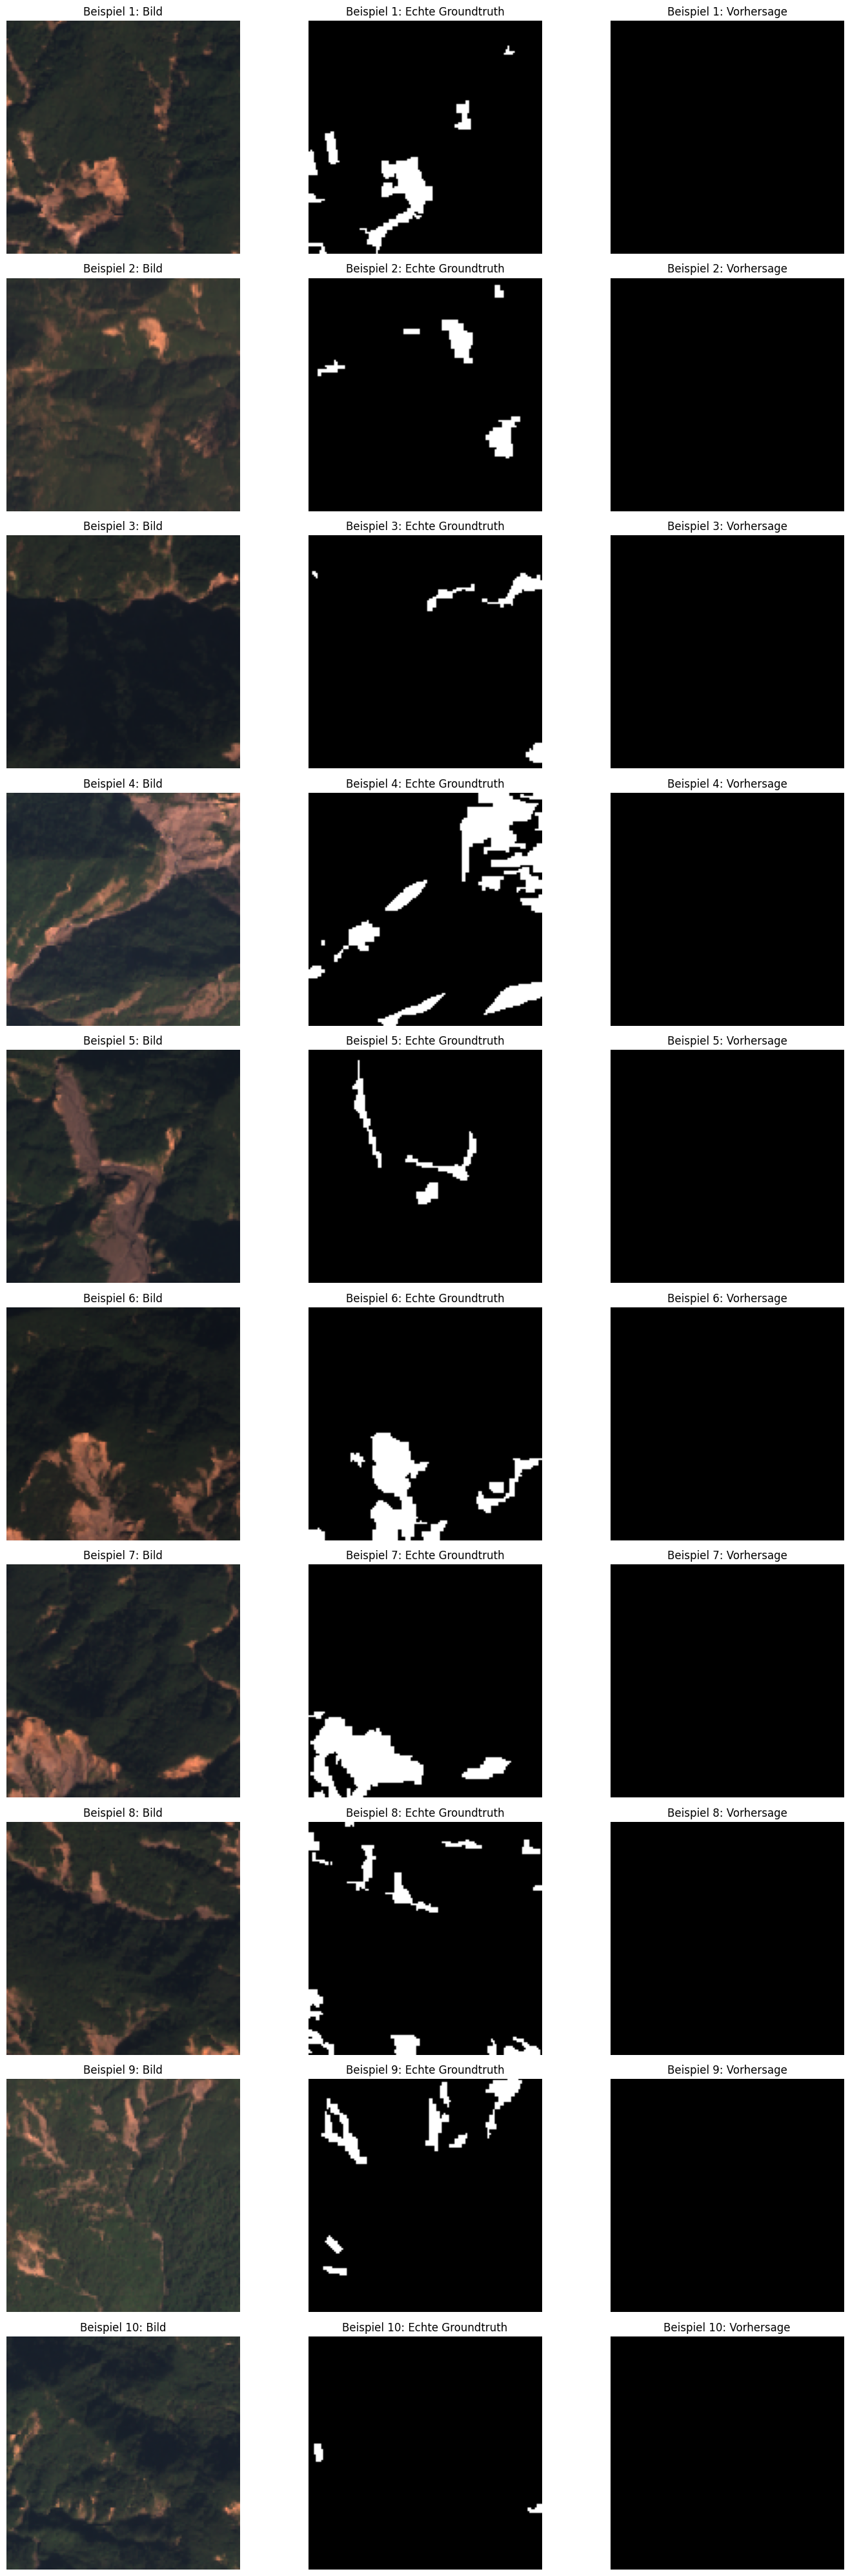

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


<Figure size 640x480 with 0 Axes>

In [18]:
sweep_overfit = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Overfit",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='to_tensor')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=2)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_deeplab(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_deeplab(test_loader, model, device)


    torch.save(model.state_dict(), "weights/model_overfit_d.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_overfit, function=main)
wandb.finish()

# Regularize

## Normalization U-Net

In [10]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Regularize Norm U-Net",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [5]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

Create sweep with ID: xujd5k9f
Sweep URL: https://wandb.ai/patschue/DLBS_Landslides%20Regularize%20Norm%20U-Net/sweeps/xujd5k9f


wandb: Agent Starting Run: z1ba9rgg with config:
wandb: 	batchsize: 64
wandb: 	epochs: 5
wandb: 	l2_penalty: 0
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using cache found in C:\Users\schue/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


0 Train loss: 0.6536912294951353 Test loss: 0.6611298173666 Test F1 Background: 0.6522351503372192 Test F1 Landslides: 0.08648113906383514
1 Train loss: 0.5628934529694644 Test loss: 0.527468740940094 Test F1 Background: 0.9773486852645874 Test F1 Landslides: 0.0451921671628952
2 Train loss: 0.5159062038768422 Test loss: 0.5021199360489845 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
3 Train loss: 0.48522490804845636 Test loss: 0.5288604646921158 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
4 Train loss: 0.4323540357026187 Test loss: 0.4525570496916771 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
Validation Loss:  0.45365901929991587 Val F1 Background:  0.9791944026947021 Val F1 Landslides:  0.0


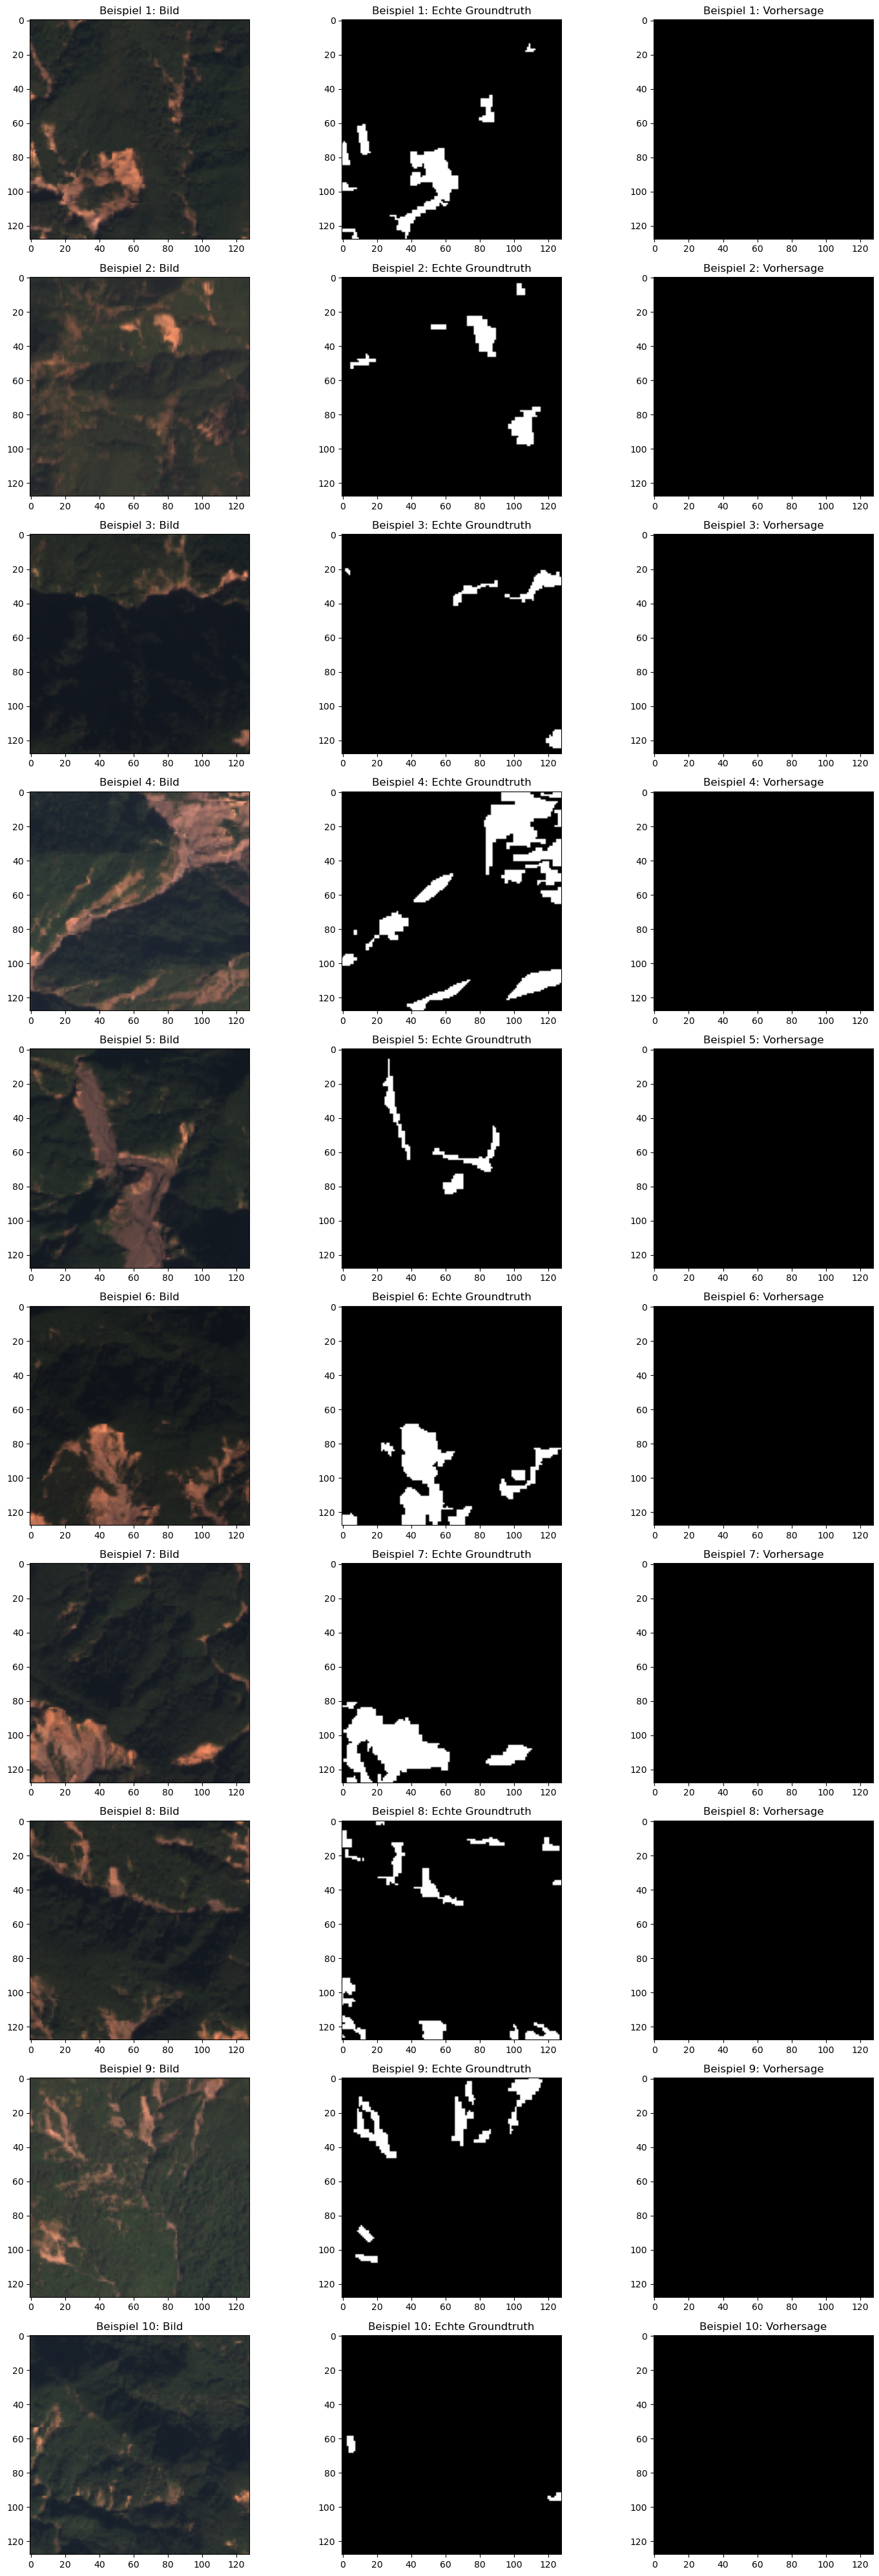

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [11]:
sweep_regularize_norm_u = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Regularize Norm U-Net",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='normalize')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=2, init_features=2, pretrained=False)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_unet(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_unet(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_regularize_norm_u.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_regularize_norm_u, function=main)
wandb.finish()

## Normalization Deeplabv3

In [ ]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Regularize Norm",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [2]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

In [ ]:
sweep_regularize_norm = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Regularize Norm",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='normalize')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=2)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_deeplab(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_deeplab(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_regularize_norm.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_regularize_norm, function=main)
wandb.finish()

## Flip U-Net

In [14]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Regularize Flip U-Net",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [80]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

Create sweep with ID: 8t2pttsj
Sweep URL: https://wandb.ai/patschue/DLBS_Landslides%20Regularize%20Flip%20U-Net/sweeps/8t2pttsj


wandb: Agent Starting Run: hd22kj48 with config:
wandb: 	batchsize: 64
wandb: 	epochs: 80
wandb: 	l2_penalty: 0
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Using cache found in C:\Users\schue/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


0 Train loss: 0.7384240058335391 Test loss: 0.7081426531076431 Test F1 Background: 0.0 Test F1 Landslides: 0.07835705578327179
1 Train loss: 0.6853025799447839 Test loss: 0.6606042981147766 Test F1 Background: 0.9754129648208618 Test F1 Landslides: 0.015189198777079582
2 Train loss: 0.639458415183154 Test loss: 0.6159399151802063 Test F1 Background: 0.9757242202758789 Test F1 Landslides: 0.013189518824219704
3 Train loss: 0.5797143578529358 Test loss: 0.5676271021366119 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
4 Train loss: 0.4840731620788574 Test loss: 0.4072720408439636 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
5 Train loss: 0.4211401492357254 Test loss: 0.4039304405450821 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
6 Train loss: 0.38819027895277197 Test loss: 0.35827312618494034 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
7 Train loss: 0.36529753695834766 Test loss: 0.35743115842342377 Test F1 Backgroun

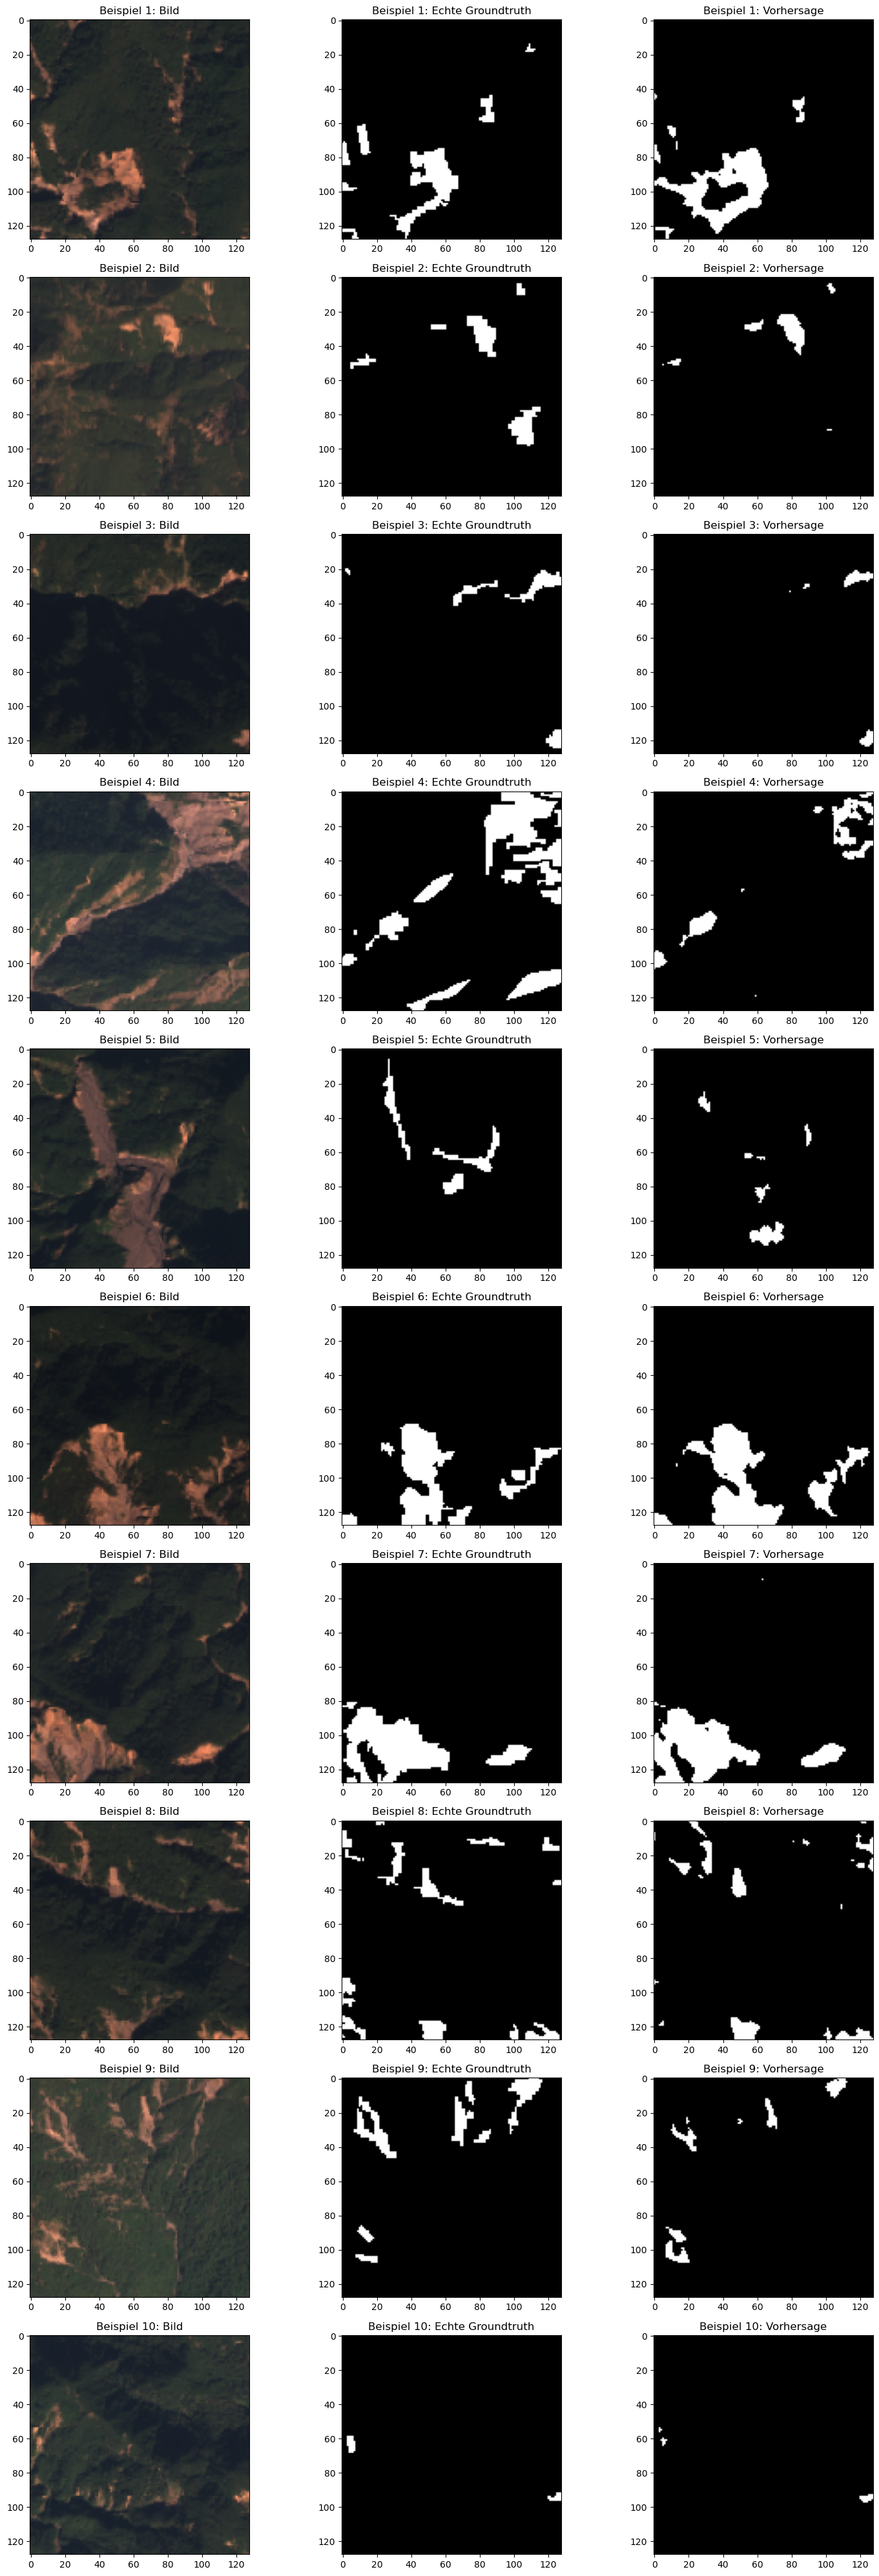

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [15]:
sweep_regularize_flip_u = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Regularize Flip U-Net",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=2, init_features=2, pretrained=False)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_unet(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_unet(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_regularize_flip_u.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_regularize_flip_u, function=main)
wandb.finish()

## Flip Deeplabv3

In [ ]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Regularize Flip",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [2]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

In [ ]:
sweep_regularize_flip = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Regularize Flip",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=2)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_deeplab(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_deeplab(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_regularize_flip.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_regularize_flip, function=main)
wandb.finish()

## L2 penalty U-Net

In [ ]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Regularize L2 U-Net",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [5]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [2e-1]},
     }
}

In [ ]:
sweep_regularize_l2_u = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Regularize L2 U-Net",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=2, init_features=2, pretrained=False)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_unet(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_unet(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_regularize_l2_u.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_regularize_l2_u, function=main)
wandb.finish()

## L2 penalty Deeplabv3

In [5]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Regularize L2",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [20]},
        "learn_rate": {"values": [5e-4]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [2e-1]},
     }
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 99hrim4o
Sweep URL: https://wandb.ai/patschue/DLBS_Landslides%20Regularize%20L2/sweeps/99hrim4o


wandb: Agent Starting Run: 21uilx08 with config:
wandb: 	batchsize: 64
wandb: 	epochs: 20
wandb: 	l2_penalty: 0.2
wandb: 	learn_rate: 0.0005
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: patschue. Use `wandb login --relogin` to force relogin


/Users/patrickschuermann/.local/share/virtualenvs/Deep_Learning-EdiEON_k/lib/python3.9/site-packages/torchmetrics/functional/classification/stat_scores.py:408: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp


0  Train loss: 0.3091623058373278 Test loss: 0.36000699549913406 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
1  Train loss: 0.14632865651087326 Test loss: 0.17010414972901344 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
2  Train loss: 0.1190506172451106 Test loss: 0.20767624862492085 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
3  Train loss: 0.10904492099176753 Test loss: 0.16524425148963928 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
4  Train loss: 0.10780099880966273 Test loss: 0.1742533426731825 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
5  Train loss: 0.10847103697332469 Test loss: 0.1590349916368723 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
6  Train loss: 0.1122970154339617 Test loss: 0.17267778143286705 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
7  Train loss: 0.12006066400896419 Test loss: 0.16489999182522297 Test F1 Background: 0.97908347845077

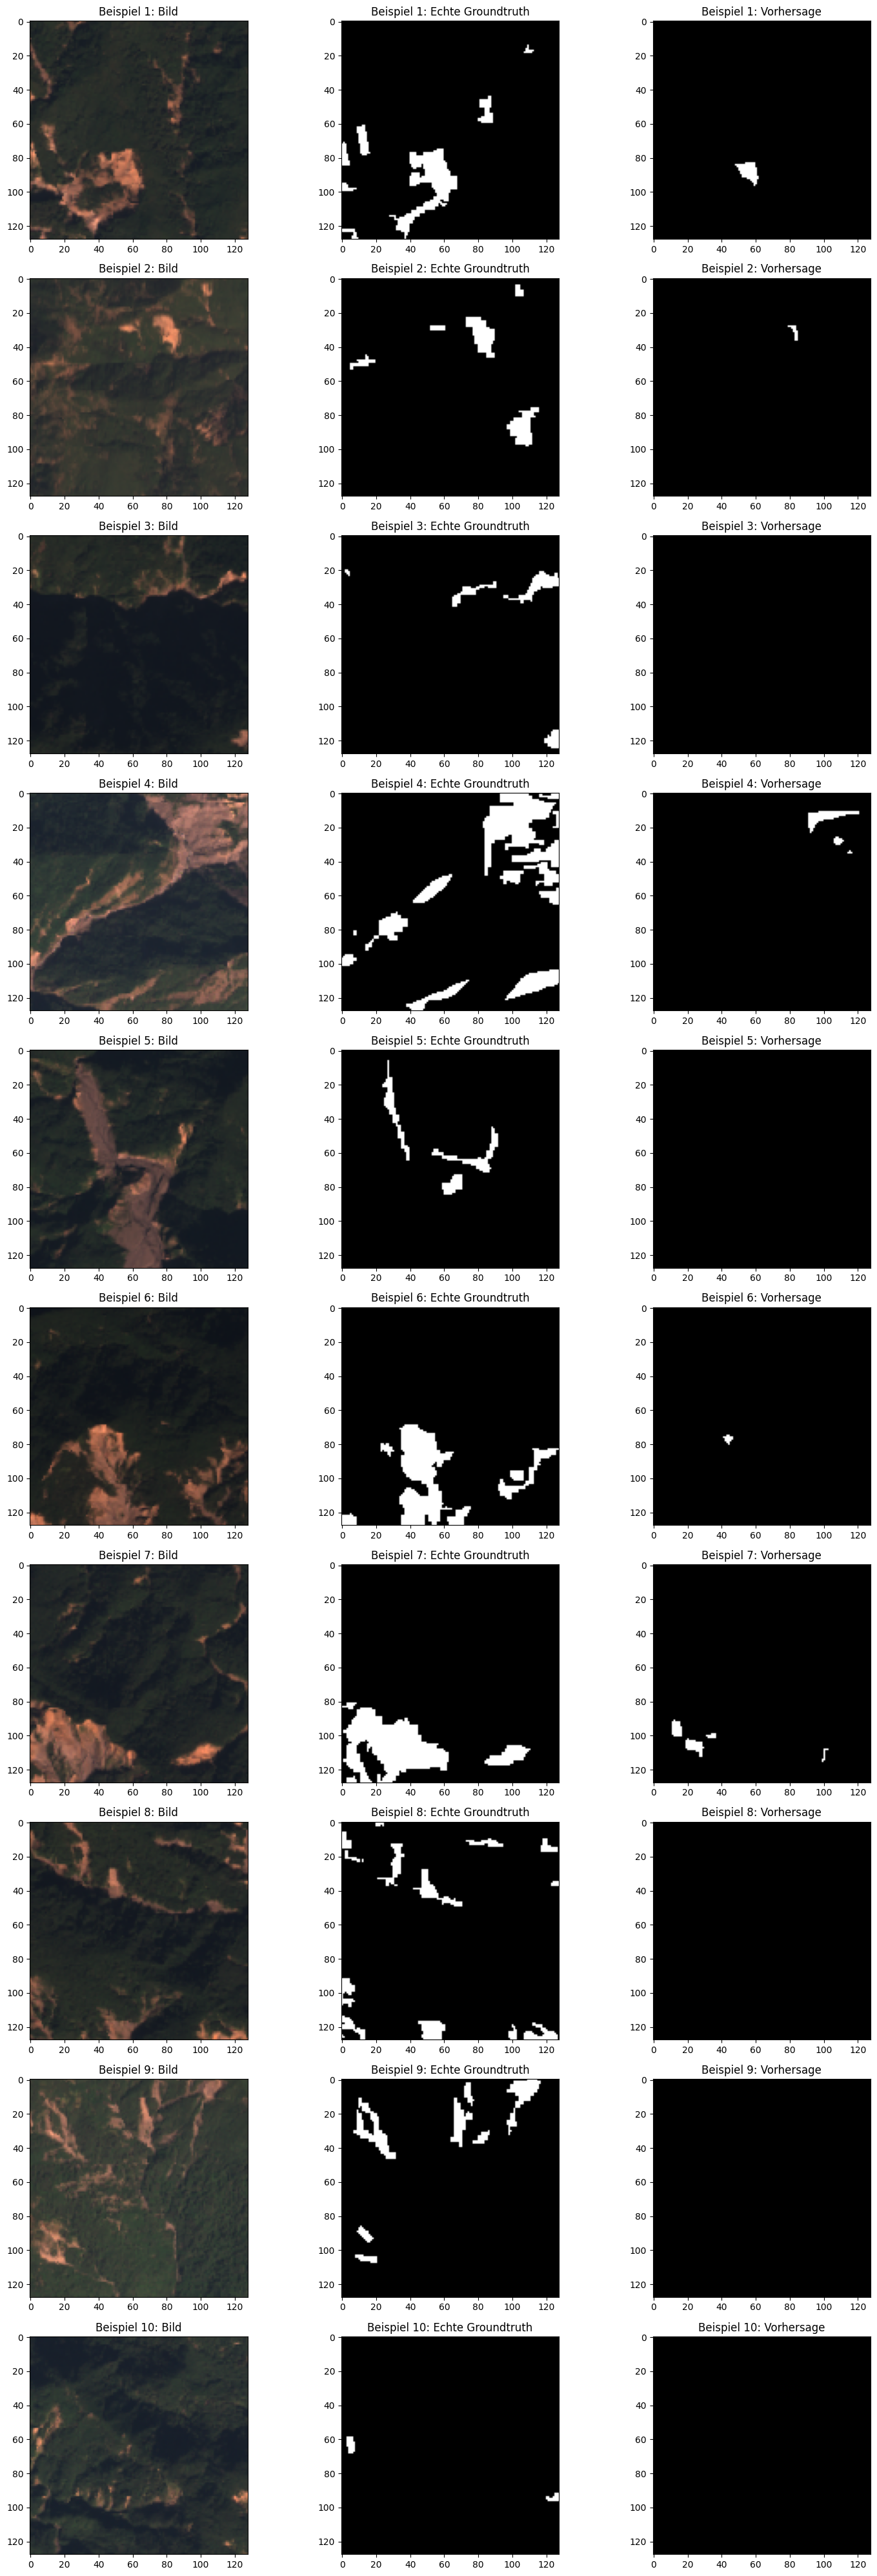

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [6]:
sweep_regularize_l2 = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Regularize L2",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=2)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_deeplab(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_deeplab(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_regularize_l2.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_regularize_l2, function=main)
wandb.finish()

# Tune

## Tune U-Net

In [ ]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Tune U-Net",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [5]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [2e-1]},
     }
}

In [ ]:
sweep_tune_u = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Tune U-Net",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=2, init_features=2, pretrained=False)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_unet(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_unet(test_loader, model, device)

    filename = "weights/model_tuning_u_lr{}_bs{}.pth".format(config.learn_rate, config.batchsize)
    torch.save(model.state_dict(), filename)

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_tune_u, function=main)
wandb.finish()

## Tune Deeplabv3

In [19]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Tune",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [2]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

In [20]:
sweep_tune = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Tune",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=2)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_deeplab(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    filename = "weights/model_tuning_lr{}_bs{}.pth".format(config.learn_rate, config.batchsize)
    torch.save(model.state_dict(), filename)

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_tune, function=main)
wandb.finish()

Create sweep with ID: iltncr7t
Sweep URL: https://wandb.ai/patschue/DLBS_Landslides%20Tune/sweeps/iltncr7t


wandb: Agent Starting Run: xgmopz66 with config:
wandb: 	batchsize: 64
wandb: 	epochs: 2
wandb: 	learn_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Training done
0  Train loss: 0.2773110700601881 Test loss: 1329428.734375 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
Training done
1  Train loss: 0.14730416068976576 Test loss: 11.17164957523346 Test F1 Background: 0.9790834784507751 Test F1 Landslides: 0.0
Validation Loss:  8.483803033828735 Val F1 Background:  0.9791943430900574 Val F1 Landslides:  0.0
Done!


wandb: Agent Starting Run: n1ovjd4l with config:
wandb: 	batchsize: 64
wandb: 	epochs: 2
wandb: 	learn_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Training done
0  Train loss: 0.30087959326126357 Test loss: 0.14606701955199242 Test F1 Background: 0.9792219400405884 Test F1 Landslides: 0.017987115308642387
Training done
1  Train loss: 0.10713844712484967 Test loss: 0.1037301504984498 Test F1 Background: 0.9816427230834961 Test F1 Landslides: 0.3004646599292755
Validation Loss:  0.10501873067447118 Val F1 Background:  0.9815583229064941 Val F1 Landslides:  0.30367615818977356
Done!


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Squeeze the Juice Out of It

# U-Net

In [ ]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Train longer U-Net",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [5]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [2e-1]},
     }
}

In [ ]:
sweep_trainlonger_u = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Train longer U-Net",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=2, init_features=2, pretrained=False)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_unet(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_unet(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_trainlonger_u.pth")


    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_trainlonger_u, function=main)
wandb.finish()

## Deeplabv3

In [ ]:
sweep_configuration = {
    "method": "grid",
    "name": "Semantische Segmentierung Train longer",
    "metric": {"goal": "minimize", "name": "Test loss"},
    "parameters": 
    {
        "epochs": {"values": [2]},
        "learn_rate": {"values": [1e-2]},
        "batchsize": {"values": [64]},
        "l2_penalty": {"values": [0]},
     }
}

In [ ]:
sweep_trainlonger = wandb.sweep(sweep=sweep_configuration, project="DLBS_Landslides Train Longer",  entity='patschue')

def main():
    run = wandb.init()

    config = run.config

    train_data = SegmentationDataset(root='data', split='train', transform_mode='flip')
    train_loader = DataLoader(train_data, batch_size=config.batchsize, shuffle=True)

    test_data = SegmentationDataset(root='data', split='test', transform_mode='to_tensor')
    test_loader = DataLoader(test_data, batch_size=config.batchsize, shuffle=False)

    val_data = SegmentationDataset(root='data', split='validation', transform_mode='to_tensor')
    val_loader = DataLoader(val_data, batch_size=config.batchsize, shuffle=False)

    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None,num_classes=2)
    model.to(device);

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learn_rate, weight_decay=config.l2_penalty)

    do_modeltrain_deeplab(config.epochs, train_loader, test_loader, val_loader, model, loss_fn, optimizer, device)

    plot_after_training_deeplab(test_loader, model, device)

    torch.save(model.state_dict(), "weights/model_trainlonger.pth")

    wandb.config["Model Name"] = model.__class__.__name__ 


wandb.agent(sweep_trainlonger, function=main)
wandb.finish()